## Data source 

The file `CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc` included as part of this binder was downloaded directly from the University of Texas Center for Space Research (CSR) website, specifically by using [this direct link](http://download.csr.utexas.edu/outgoing/grace/RL06_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc). For general information on this dataset, please [visit the official site here](https://www2.csr.utexas.edu/grace/RL06_mascons.html). Acknowledgement/citation should be made to the following reference as well as others mentioned in the link above. 

Save, H., S. Bettadpur, and B.D. Tapley (2016), High resolution CSR GRACE RL05 mascons, J. Geophys. Res. Solid Earth, 121, doi:[10.1002/2016JB013007](http://dx.doi.org/10.1002/2016JB013007).


### Optional: Update the data 

The next cell might be used to update the file with the most recent version, however note that the file is about 800M. 

In [ ]:
# Section of code to download the GRACE mass concentration (mascon) data from UT-CSR
# It is not necessary to run this cell. Only use it if you want the existing nc file is out of date.
import os
csr_file = 'CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc'
url = 'http://download.csr.utexas.edu/outgoing/grace/RL06_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc'
import requests
r = requests.get(url)
grace_data = r.content
with open(csr_file, 'wb') as f:
    f.write(grace_data)

### Load the GRACE data

The next cell loads the GRACE data from the netCDF into an [xarray.DataSet](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)

In [1]:
import xarray as xr
import rioxarray  # required to clip the dataset later in the notebook.
csr_file="CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc"
csr_data = xr.open_dataset(csr_file)
# Technical note: the netcdf above breaks a CF convention
# by capitalizing the units attribute (i.e. should be "units" and not "Units"). 
# Here we assign the correct one (not capitalized) so that xarray
# can decode the time correctly:
csr_data.time.attrs.update(units=csr_data.time.Units)
csr_data = (xr.decode_cf(csr_data)
.rename({'lon':'x', 'lat':'y'})
.drop_vars("time_bounds")
.rio.write_crs("epsg:4326")
)

## Region of study

The file `Saq.geojson` is included as an example region of study to calculate depletion trends. Optionally use a different shape by loading it directly as a geojson dictionary and then converting it into a geopandas dataframe. 

In [2]:
import json
import geopandas as gpd 
shp = gpd.read_file("Saq.geojson") # Example region of study included in binder as a geojson file. 
# Optionally replace the shape by pasting a geojson dictionary here:
example_shp_as_json_dict = \
{
    "type":"FeatureCollection",
    "features":[
        {"geometry":
         {"coordinates":[[
             [35.375, 24.434366],
             [35.375, 32.124512],
             [45.835997, 32.124512],
             [45.835997, 24.434366],
             [35.375, 24.434366]
         ]],
          "type":"Polygon"},
         "properties":{},
         "type":"Feature"}]
}
# Uncomment this line to replace shp with the above geojson dict:
#shp = gpd.GeoDataFrame.from_features(example_shp_as_json_dict, crs="epsg:4326")

shp.explore(tiles="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}", attr="Google basemap")

## Clip the data to the shape

The next cell clips the xarray.Dataset using two steps: (1) clip to the bounding box, (2) clip to the shape.

In [3]:
csr_data_box = csr_data.rio.clip_box(**shp.bounds.iloc[0].to_dict())  # First clip to the box around our shape
clipped = csr_data.rio.clip(shp.geometry.values, shp.crs).drop("WGS84") # now clip to the shape
clipped

<xarray.Dataset>
Dimensions:        (time: 212, x: 41, y: 30)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-18 ... 2022-08-16T12:00:00
  * x              (x) float32 35.62 35.88 36.12 36.38 ... 45.12 45.38 45.62
  * y              (y) float32 24.62 24.88 25.12 25.38 ... 31.38 31.62 31.88
Data variables:
    lwe_thickness  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL06_Mascons_all-co...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL06Mv2
    subtitle:                   GRACE/GRACE-FO Total water storage with all c...
    ...                         ...
    user_note_2:                The accelerometer on the GRACE-FO 2 spacecraf...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    date_created:               2022-10-11T11:36:56Z
    variable:                   liquid water equivalent thickness
    label:                      RL06rc24cE
    Mask:                       Global

## Reduce data to time series

We now reduce the datacube to a time series by taking the spatial average on each time step. The result is given here as a [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

In [4]:
# Spatial mean at each time to get time series; 
# convert to pandas dataframe
ts_saq = (clipped
.lwe_thickness.mean(dim=["x","y"]) 
.to_dataframe()                    
.rename_axis("date")
.rename(columns={"lwe_thickness":"twsa"})
)
ts_saq.twsa = ts_saq.twsa*10  # cm -> mm
ts_saq

,twsa
date,
2002-04-18 00:00:00,35.409122
2002-05-10 12:00:00,23.358267
2002-08-16 12:00:00,29.020578
2002-09-16 00:00:00,17.873837
2002-10-16 12:00:00,42.233959
...,...
2022-04-16 00:00:00,-194.191147
2022-05-16 12:00:00,-233.540344
2022-06-16 00:00:00,-196.020386


## Calculate a simple linear trend

Here we calculate a simple linear trend using [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). The trend is given in mm.yr⁻¹.

Use the next cell to select the start and end period for the trend.

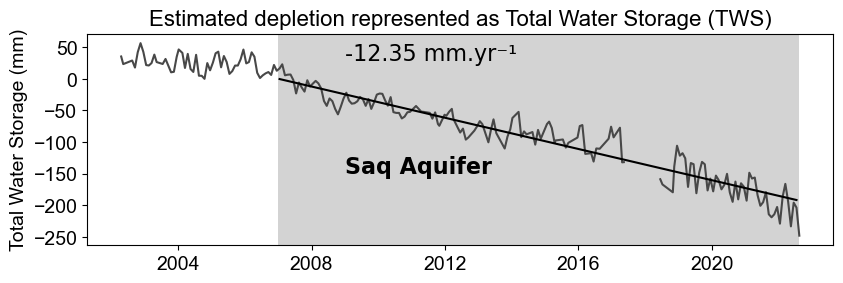

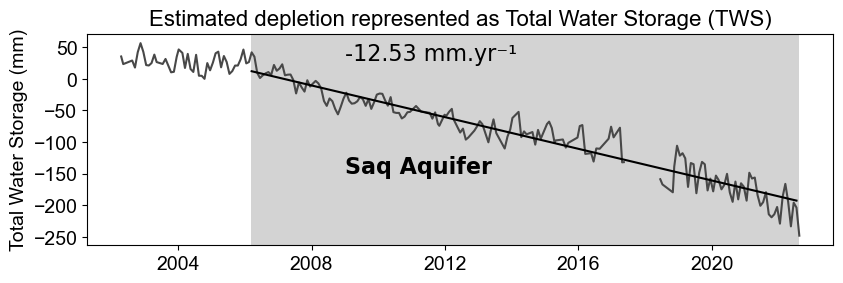

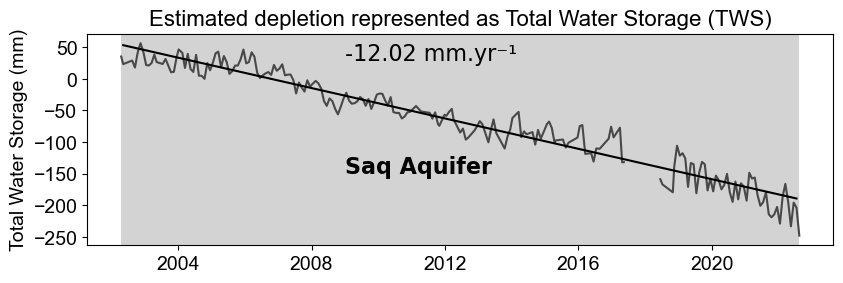

In [8]:
# Code from:
# https://stackoverflow.com/questions/68852445/ipywidget-datepicker-interact-with-selectionrangeslider-problem
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd
import ipywidgets as widgets
default_start_date = datetime(2007, 1, 1)
default_end_date = datetime(2022, 8, 15)
start_date = datetime(2002, 1, 1)
end_date = datetime(2022, 12, 31)
dates = pd.date_range(start_date, end_date, freq='D')
options = {date.strftime(' %d %b %Y '): date for date in dates}
pick_start = widgets.DatePicker(
    description='',
    disabled=False,
    value = default_start_date
)
pick_end = start_day = widgets.DatePicker(
    description='',
    disabled=False,
    value=default_end_date
)
selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=(0, len(options) - 1),
    description='Trend period',
    orientation='horizontal',
    layout=widgets.Layout(width='100%', padding='35px')
)
def update_pick(*args):
    pick_start.value = selection_range_slider.value[0]
    pick_end.value = selection_range_slider.value[1]

def update_slider(*args):
    selection_range_slider.value =  (pick_start.value, pick_end.value)
selection_range_slider.observe(update_pick, 'value')
pick_start.observe(update_slider, 'value')
pick_end.observe(update_slider, 'value')
center_layout = widgets.Layout(display='flex',
                                       align_items='center',
                                       width='100%')
day = widgets.HBox(children=[pick_start, selection_range_slider, pick_end], layout=center_layout)

# Calculate the trend:
def trend_in_mm_year(df, y="twsa"):
    """Calculate a linear trend in mm/year
    The df.index are the dates
    """
    import pandas as pd
    import sklearn.linear_model
    model = sklearn.linear_model.LinearRegression()

    model.fit(df.index.values.reshape(-1, 1), df[y])
    trend = model.coef_*1e9*3600*24*365  # in mm/year
    # Note that the .astype(float) makes the date
    # a numeric value in nanoseconds! 
    y_pred = model.predict(df.index.values.astype(float).reshape(-1,1))
    y_pred = pd.Series(y_pred, index=df.index)
    return trend, y_pred
    

hfont = {'fontname':'Arial'}
height=2.75
AR=3.5
width = height*AR


def calc_trend(value):
    dates = value['new']
    tstart = dates[0]
    tend = dates[1]
    data = ts_saq.copy()
    trend, y_pred = trend_in_mm_year(data.query("date>=@tstart and date<=@tend"))   
    #print(trend) 
    data = data.assign(linear_twsa=y_pred)

    # Preview time series using seaborn
    og_grace_query="date<='2017-05-23'"
    gracefo_query="date>='2018-06-01'"

    fig =  plt.figure(figsize=(width, height))  
    ax = fig.add_subplot(1, 1, 1)
    sns.lineplot(data=data.query(og_grace_query), x="date", y="twsa", color="#484848", ax=ax)
    sns.lineplot(data=data.query(gracefo_query), x="date", y="twsa", ax = ax, color="#484848")
    # Linear trend:
    sns.lineplot(data=data.query("date>@tstart"), x="date", y="linear_twsa", ax = ax, color="black")

    ax.set_xlabel("")
    ax.set_ylabel("Total Water Storage (mm)", fontsize=14, **hfont)
    ax.set_title("Estimated depletion represented as Total Water Storage (TWS)", fontsize=16, **hfont)

    # "Saq aquifer" annotation:
    annotate_kws = {"size": 16, "xytext": (0,0), "textcoords": "offset points", "fontweight": "bold"}
    ax.annotate("Saq Aquifer", (pd.to_datetime("2009-01-01"), -150), **annotate_kws)

    # "- X mm.yr^-1" annotation:
    trend_annot = "{:.2f} mm.yr⁻¹".format(trend[0])
    annotate_kws = {"size": 16, "xytext": (0,0), "textcoords": "offset points"}
    ax.annotate(trend_annot, (pd.to_datetime("2009-01-01"), 30), **annotate_kws)

    plt.setp(ax.get_yticklabels(), fontsize=14, **hfont)
    plt.setp(ax.get_xticklabels(), fontsize=14, **hfont)

    plt.axvspan(tstart, tend, facecolor='#D3D3D3')

    plt.rcParams['svg.fonttype'] = 'none' # so that the
    # fonts in the exported svg can be edited e.g. in powerpoint.  
    #plt.savefig('../images/GRACE_figure_updated_2022_v4.svg', dpi = 600, bbox_inches = 'tight', transparent = True)
    #fig.canvas.draw()
    
selection_range_slider.observe(calc_trend, 'value')
update_slider('value')

display(day)